# dIdV Fit Development

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from pprint import pprint
from scipy import signal
from pytesdaq.processing import _iv_didv_tools_plotting as plot
import qetpy as qp
from pytesdaq.io.hdf5 import H5Reader

### Load dIdV data

In [2]:
group_path = '/sdata2/runs/run24/raw/iv_didv_I2_D20221216_T222101'
#series_nums = [220221216223932] # 4uA
series_nums = [220221216224139] # 3uA
chan = 'Melange025pcRight'

h5read = H5Reader()
traces, metadata = h5read.read_many_events(
    filepath = group_path,
    nevents=-1,
    output_format=2,
    detector_chans=chan,
    series_nums=series_nums,
    include_metadata=True,
    adctoamp = True
)

traces = np.squeeze(traces, axis=1)
print('Channel ' + chan + ' dIdV settings:\n' )
print('Traces shape: ' + str(traces.shape))

# TES bias
tes_bias = float(metadata[0]['detector_config'][chan]['tes_bias'])
print('Bias current [uA] = ' + str(tes_bias*1e6))
      

# signal generator
sgfreq = float(metadata[0]['detector_config'][chan]['signal_gen_frequency'])
sgamp = float(metadata[0]['detector_config'][chan]['signal_gen_current'])
sgvolt = float(metadata[0]['detector_config'][chan]['signal_gen_voltage'])

print('Signal generator voltage [mV] = ' + str(sgvolt*1000))
print('Signal generator frequency  [Hz] = ' + str(sgfreq))

# sample rate
fs = float(metadata[0]['sample_rate'])


Channel Melange025pcRight dIdV settings:

Traces shape: (270, 131250)
Bias current [uA] = 3.0525030525030274
Signal generator voltage [mV] = 9.999999776482582
Signal generator frequency  [Hz] = 20.0


### Quality cuts

In [3]:
# define cuts autocuts with is_didv=True
cut = qp.autocuts(traces, fs=fs, is_didv=True)
traces_cut = traces[cut]
print('Cut efficiency [%] = ' + str(traces_cut.shape[0]/traces.shape[0]*100))

Cut efficiency [%] = 66.2962962962963


### Display mean selected traces

Text(0, 0.5, 'Amplitude [uA]')

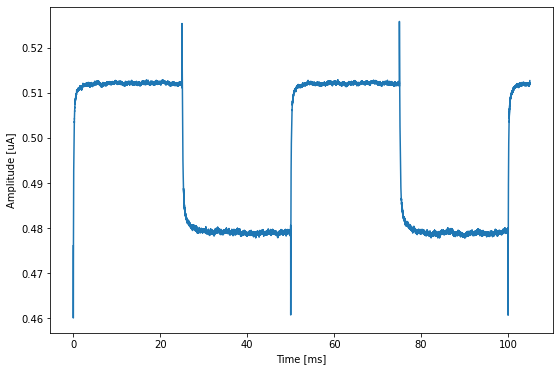

In [4]:
# display mean (with low pass)
trace_mean = np.mean(traces_cut, axis=0)

# low pass
nyq = fs/2
cut_off = 100e3/nyq
b,a = signal.butter(4, cut_off)
trace_mean =  signal.filtfilt(b, a, trace_mean,padtype='even')

# plot
fig, ax = plt.subplots(figsize=(9,6))
dt = 1000/fs
bins = np.asarray(list(range(trace_mean.shape[-1])))*dt
plt.plot(bins, trace_mean*1e6)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Amplitude [uA]")

### Instantiate QETpy dIdV fit

In [5]:
rp = 3e-3
r0 = 121.5e-3
rsh = 5e-3
dt0_guess = 2e-6

didvobj = qp.DIDV(
    traces_cut,
    fs,
    sgfreq,
    sgamp,
    rsh,
    tracegain=1.0,
    r0=r0, # the expected r0 should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    rp=rp, # the expected rp should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    dt0=dt0_guess, # a good estimate of the time shift value will likely speed up the fit/improve accuracy
    add180phase=False, # if the fits aren't working, set this to True to see if the square wave is off by half a period
)

# preliminary calculation
didvobj.processtraces()

### Default 2-pole dIdV Fit parameter guess from QETpy

Let's see how QETpy is guessing the initial 2-pole fit parameters

<IPython.core.display.Javascript object>


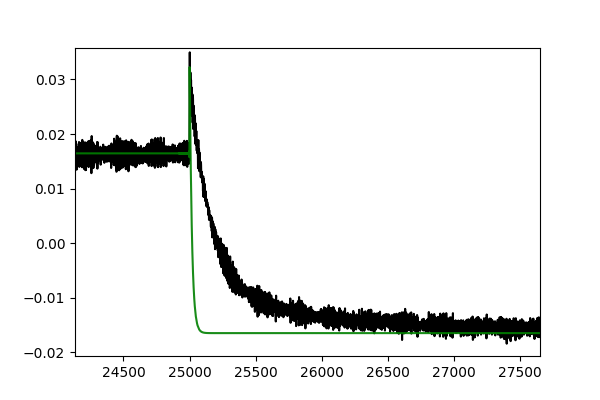

In [6]:
%matplotlib notebook
# let's look at the parameter geussed by QETpy code 
A0, B0, tau10, tau20, isloopgainsub1 = didvobj._guessdidvparams(
                didvobj._tmean,
                didvobj._tmean[didvobj._flatinds],
                sgamp,
                rsh,
                L0=1.0e-7,
            )
            
# calculate guessed dIdV 
guess_fit = didvobj._convolvedidv(
            didvobj._time, A0, B0, 0, tau10, tau20, 0, 
            didvobj._sgamp, rsh, didvobj._sgfreq, 
            didvobj._dutycycle,
        )

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(didvobj._time*1e6,
        (didvobj._tmean-didvobj._offset)*1e6,
        color='k',
        label='Mean',)

ax.plot((didvobj._time + dt0_guess)*1e6,
        guess_fit*1e6,
        color='green',
        alpha=0.9,
        label='2-Pole Fit',
       )


###  2-pole Fit with default QETpy setup

QETpy uses scipy.optimize.least_squares

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4071e+05                                    2.00e+10    
       1              2         1.1813e+05      1.23e+05       1.06e-01       7.33e+09    
       2              3         5.8019e+04      6.01e+04       3.05e-02       2.39e+09    
       3              4         4.1121e+04      1.69e+04       2.18e-02       4.13e+08    
       4              5         3.8365e+04      2.76e+03       2.89e-02       3.36e+08    
       5              6         3.8129e+04      2.36e+02       5.89e-03       3.04e+08    
       6              7         3.8112e+04      1.65e+01       6.31e-04       1.65e+08    
       7              8         3.8107e+04      5.05e+00       1.53e-04       1.64e+08    
       8              9         3.8107e+04      2.98e-01       1.26e-04       1.08e+08    
       9             10         3.8106e+04      7.24e-01       5.37e-05       6.00e+07    

<IPython.core.display.Javascript object>


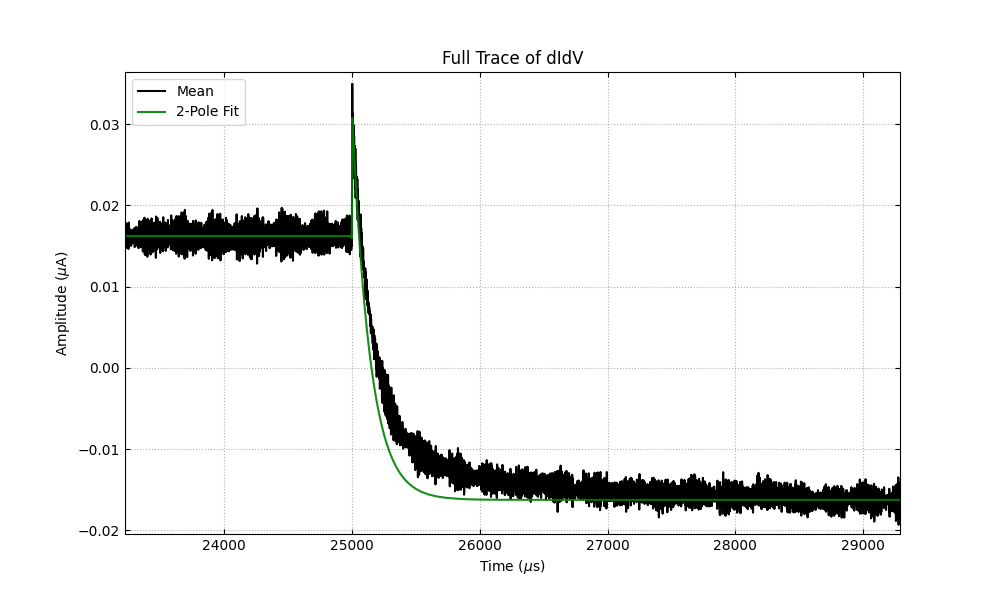

<IPython.core.display.Javascript object>


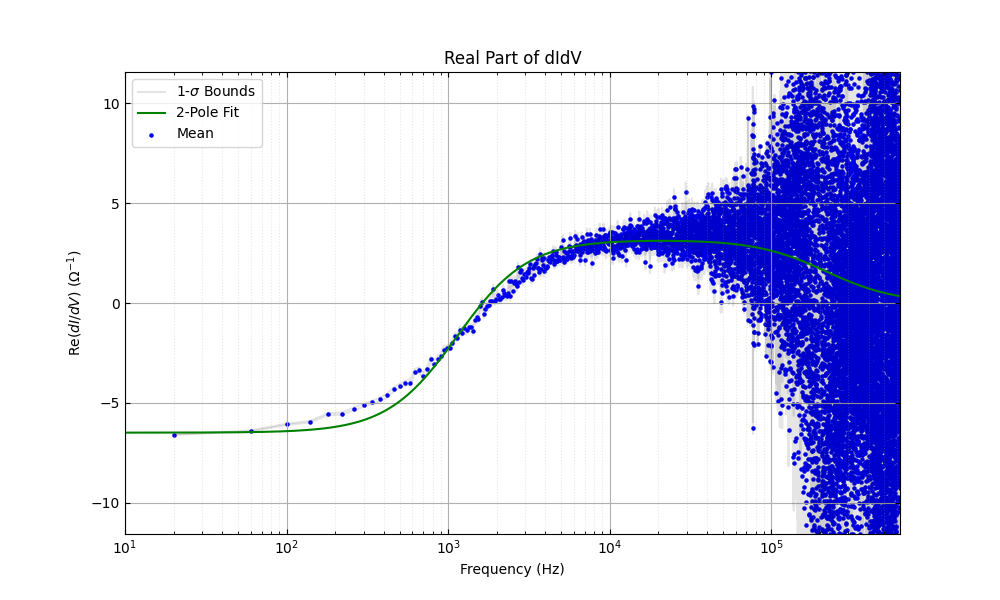

<IPython.core.display.Javascript object>


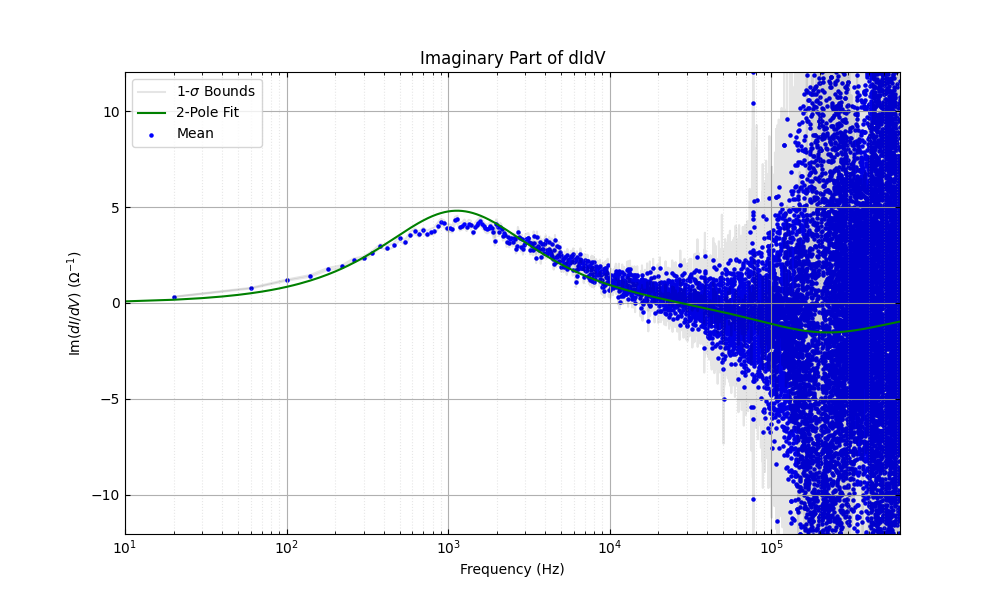

In [7]:
%matplotlib notebook

# Do fit ad get result 
didvobj.dofit(2, verbose=2)
result = didvobj.fitresult(2)


# display result
didvobj.plot_full_trace()
#didvobj.plot_single_period_of_trace()
#didvobj.plot_re_vs_im_dvdi()
didvobj.plot_re_im_didv()

### 2-pole fit with low pass cutoff of 2e4 Hz

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9692e+05                                    1.77e+10    
       1              2         8.6910e+04      1.10e+05       7.99e-02       5.74e+09    
       2              3         2.3010e+04      6.39e+04       5.06e-02       2.51e+09    
       3              4         5.6598e+03      1.74e+04       3.45e-03       2.32e+08    
       4              5         4.2066e+03      1.45e+03       3.45e-02       1.31e+08    
       5              6         4.1277e+03      7.89e+01       9.43e-03       3.61e+07    
       6              7         4.0861e+03      4.17e+01       2.50e-03       7.71e+06    
       7              8         4.0841e+03      1.99e+00       2.92e-04       1.63e+06    
       8              9         4.0840e+03      1.16e-01       1.23e-05       3.74e+05    
       9             10         4.0840e+03      1.41e-02       1.48e-04       8.37e+04    

<IPython.core.display.Javascript object>


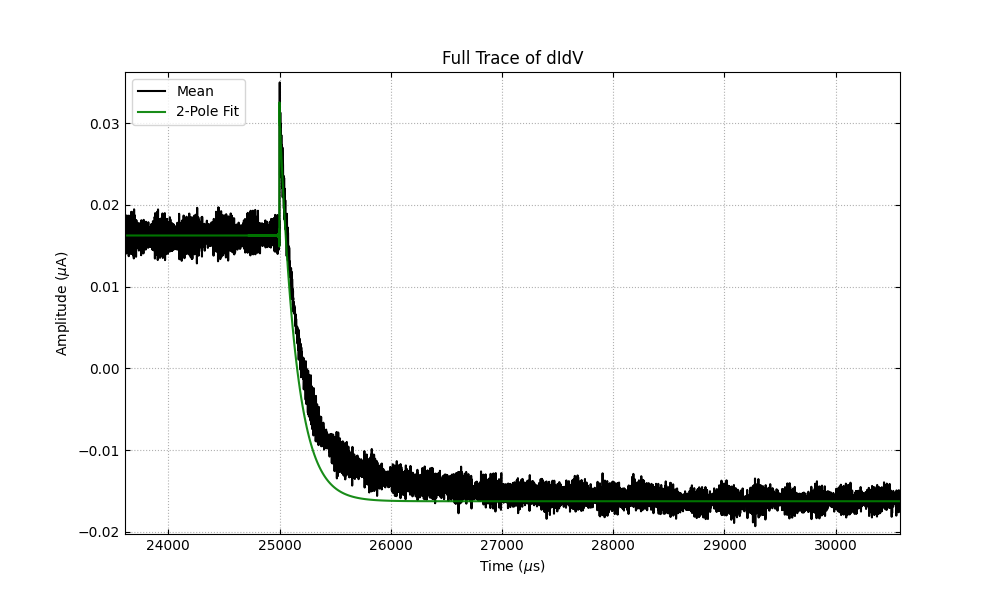

<IPython.core.display.Javascript object>


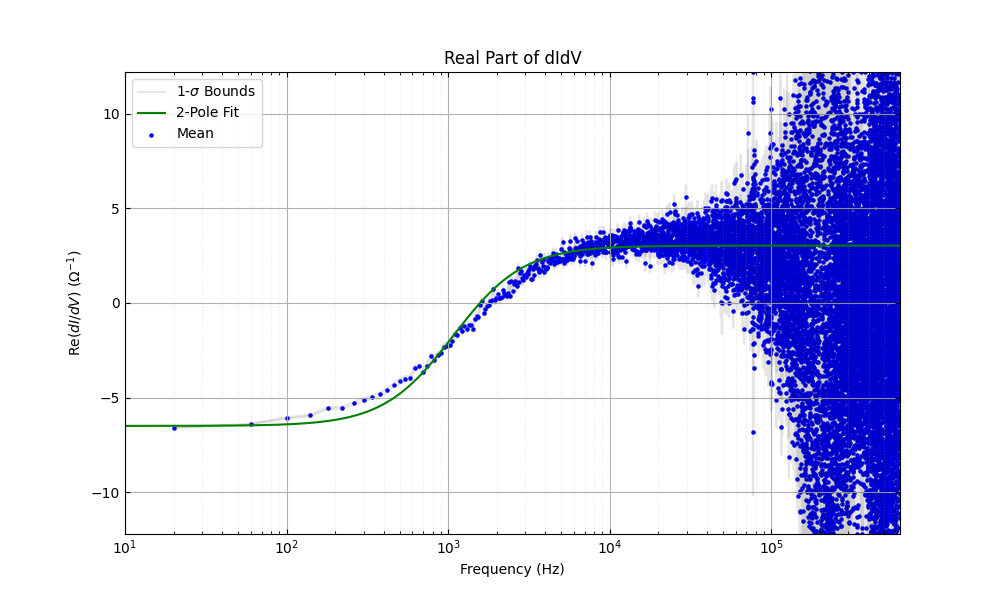

<IPython.core.display.Javascript object>


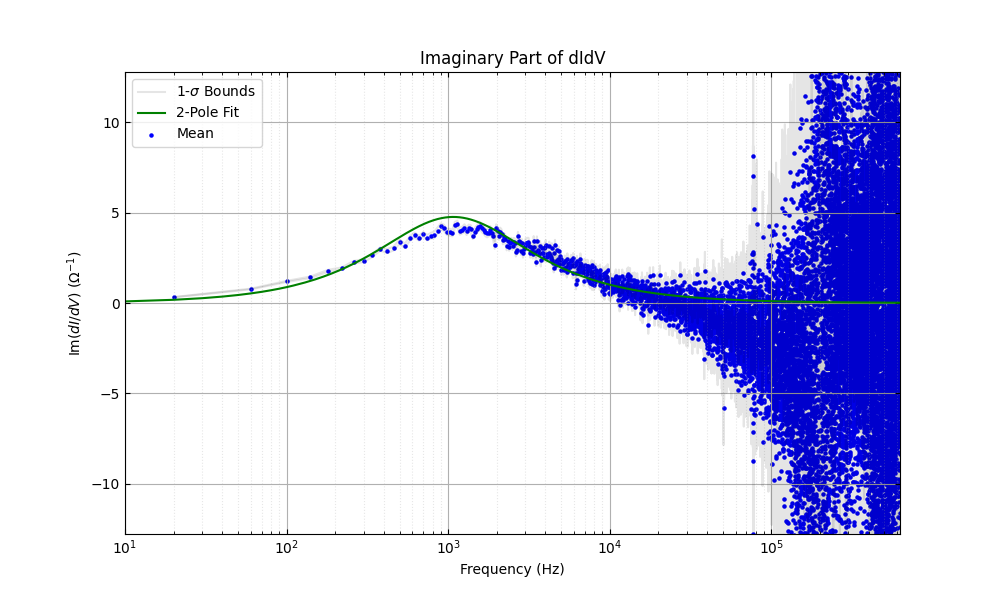

In [8]:
%matplotlib notebook

# Do fit ad get result 
didvobj.dofit(2, fcutoff=2e4, verbose=2)
result = didvobj.fitresult(2)


# display result
didvobj.plot_full_trace()
#didvobj.plot_single_period_of_trace()
#didvobj.plot_re_vs_im_dvdi()
didvobj.plot_re_im_didv()

### Use better initial values (from previous fit) and strict lower/upper bounds

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4627e-39                                    1.48e-39    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 2.4627e-39, final cost 2.4627e-39, first-order optimality 1.48e-39.


<IPython.core.display.Javascript object>


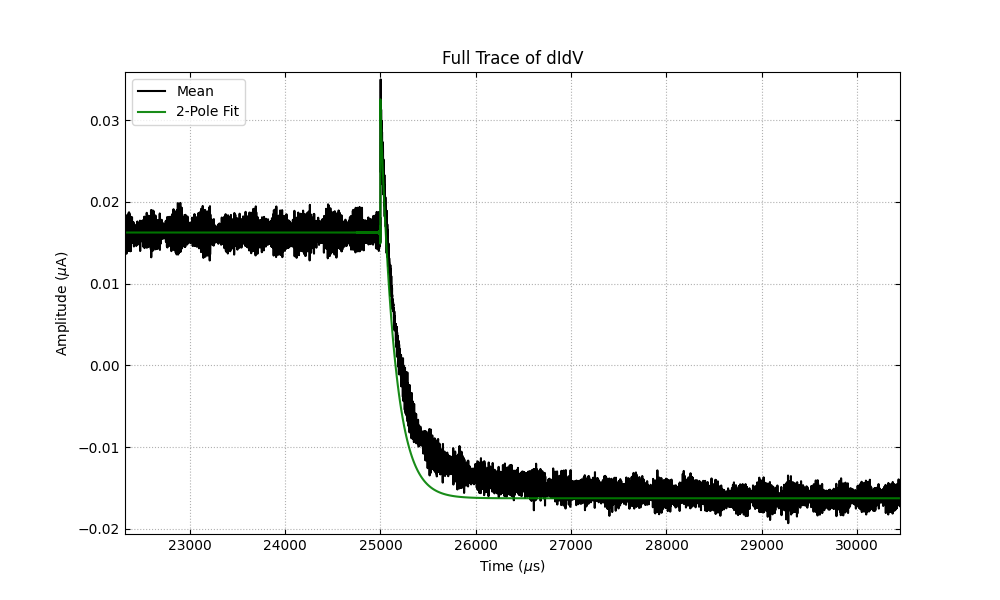

<IPython.core.display.Javascript object>


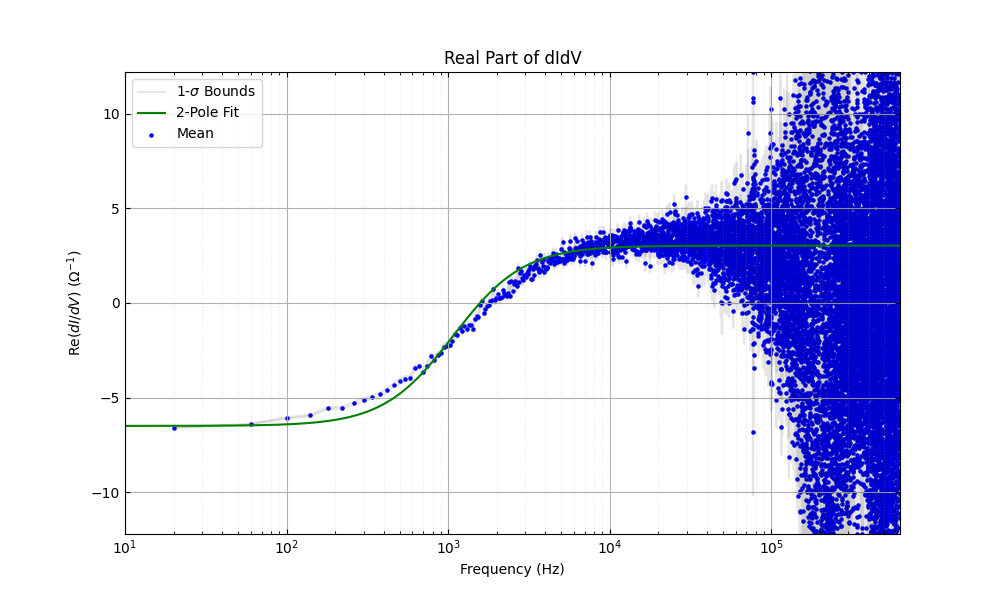

<IPython.core.display.Javascript object>


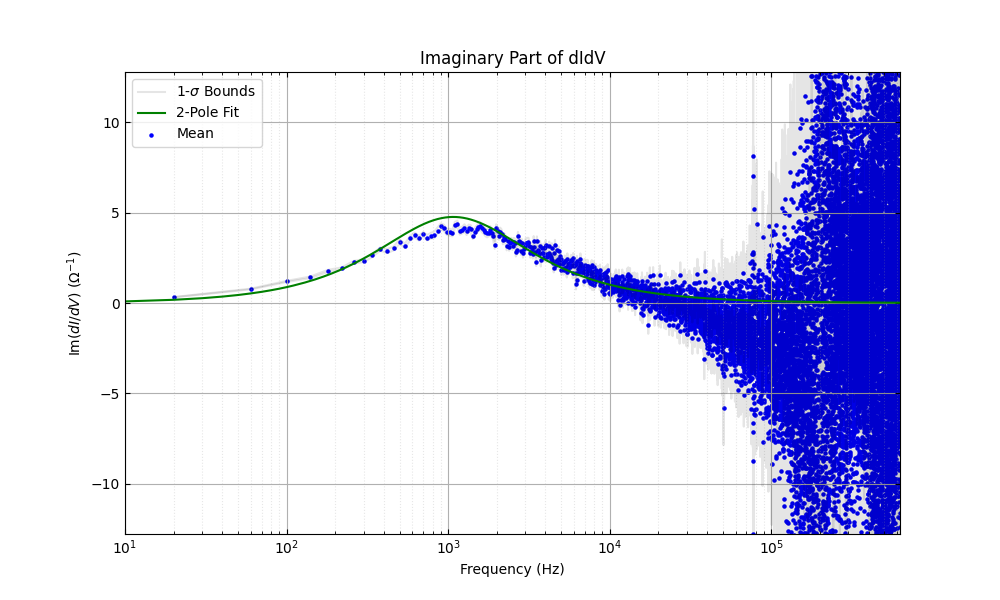

In [22]:
# param order: A0, B0, tau10, tau20, dt
# To fix parameter: same value up/down

#DEfault QETpy default bounds when loopgain>1 
#bounds = ((0.0, -np.inf, -np.inf, 0.0, -np.inf),
#          (np.inf, 0.0, 0.0, np.inf, np.inf),
#         )

# let's use previous fit result for initial values


guess_params  = [result['params']['A'], result['params']['B'],
                 result['params']['tau1'],result['params']['tau2'],
                 result['params']['dt']]

#print(guess_params)


bounds = ((guess_params[0]-0.05, guess_params[1]-0.05, -1e-4, 1e-10, guess_params[4]-1e-8),
          (guess_params[0]+0.05, guess_params[1]+0.05, -1e-6, 1.7e-10,  guess_params[4]+1e-8),
         ) 

    
didvobj.dofit(2, fcutoff=2e-4, 
              guess_params=guess_params, bounds=bounds, ftol=1e-8, verbose=2)

#display result
didvobj.plot_full_trace()
#didvobj.plot_single_period_of_trace()
#didvobj.plot_re_vs_im_dvdi()
didvobj.plot_re_im_didv()